In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
pd.set_option('display.max_rows',2000,'display.max_columns',50)


In [2]:
os.chdir('/Users/vinsmokegenji/Desktop/Campaign Finance Project')
df_total = pd.read_csv('Expenditures and Results.csv')
df_total.drop(columns = ['Unnamed: 0','Group'],inplace=True)
df_total

,Candidate Name,Party,Office,District,Total Amount,election_year,election_type,CanNameLast,CanNameFirst,TotalCanVotes_general,TotalCanVotes_primary,TotalCanVotes_runoff,MaxVotesInRace_general,MaxVotesInRace_primary,MaxVotesInRace_runoff,Won_general,Won_primary,Won_runoff,RaceVoterPool_general,RaceVoterPool_primary,RaceVoterPool_runoff
0,"Kou, Bowen",REP,STS,13.0,1376551.88,2024,General,Kou,Bowen,NaN,10607.0,NaN,NaN,29729.0,NaN,NaN,0.0,NaN,NaN,44354.0,NaN
1,"Leek, Tom",REP,STS,7.0,708650.51,2024,General,Leek,Tom,NaN,35938.0,NaN,NaN,35938.0,NaN,NaN,1.0,NaN,NaN,75971.0,NaN
2,"Tant, Allison",DEM,STR,9.0,632922.67,2024,General,Tant,Allison,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Parks, Daryl",DEM,STS,3.0,603755.84,2024,General,Parks,Daryl,NaN,42097.0,NaN,NaN,42097.0,NaN,NaN,1.0,NaN,NaN,55787.0,NaN
4,"Lopez, Suzy",REP,STA,13.0,601181.07,2024,General,Lopez,Suzy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6728,"Naaman, Fred A.",REP,STR,115.0,5.00,1996,General,Naaman,Fred A.,NaN,1249.0,NaN,NaN,8968.0,NaN,NaN,0.0,NaN,NaN,10217.0,NaN
6729,"Feeney, Tom",REP,STR,33,149918.00,1996,House_33,Feeney,Tom,7105.0,2083.0,NaN,7105.0,2083.0,NaN,1.0,1.0,NaN,12969.0,3551.0,NaN
6730,"Hattaway, Jim",DEM,STR,33,94836.59,1996,House_33,Hattaway,Jim,5864.0,NaN,NaN,7105.0,NaN,NaN,0.0,NaN,NaN,12969.0,NaN,NaN
6731,"Hampton, Phillip E.",REP,STR,33,9792.13,1996,House_33,Hampton,Phillip E.,NaN,1468.0,NaN,NaN,2083.0,NaN,NaN,0.0,NaN,NaN,3551.0,NaN


# Final data cleaning and preparation

## Normalizing District variable

In [5]:
df_total['District']
df_total['District'] = (
    df_total['District']
    .fillna('999')
    .replace({' ': '999', 'nan': '999'})  # Replace blanks or string 'nan' with None
    .str.lstrip('0') # stripping unnecessary left and right 0's
    .str.replace(r'\.0$', '', regex=True)
    .astype(int) #converting all to integer
)

In [6]:
np.sort(df_total['District'].unique())

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 999])

## Adding context variables
1. Ranking place of each candidate in each election (1st, 2nd, 3rd, etc)
2. Adding a vote share variable (% of voter pool)
3. Total Race Expenditure + renaming Total Amount to Candidate Expenditure

In [12]:
df_total['Place_general'] = df_total.groupby(['election_year','election_type'
                                                ,'Office','District'])['TotalCanVotes_general'].transform(
                                                 lambda x: x.rank(ascending=False, method='min'))
df_total['Place_primary'] = df_total.groupby(['election_year','election_type','Office'
                                                ,'District','Party'])['TotalCanVotes_primary'].transform(
                                                 lambda x: x.rank(ascending=False, method='min'))
df_total['Place_runoff'] = df_total.groupby(['election_year','election_type','Office'
                                                ,'District','Party'])['TotalCanVotes_runoff'].transform(
                                                 lambda x: x.rank(ascending=False, method='min'))

In [13]:
df_total['VoteShare_general'] = df_total['TotalCanVotes_general']/df_total['RaceVoterPool_general']
df_total['VoteShare_primary'] = df_total['TotalCanVotes_primary']/df_total['RaceVoterPool_primary']
df_total['VoteShare_runoff'] = df_total['TotalCanVotes_runoff']/df_total['RaceVoterPool_runoff']

In [16]:
df_total['Race_expenditure'] = df_total.groupby(['election_year','election_type'
                                                ,'Office','District'])['Total Amount'].transform('sum')
df_total2 = df_total.rename(columns = {'Total Amount':'Candidate_expenditure'})

## Rearanging columns

In [19]:
cols = df_total2.columns.tolist()
#print(cols)
cols2 = cols[5:7] + [cols[0]] + cols[7:9] + cols[1:5] + [cols[-1]]
for i in range(0,3):
    cols2 = cols2 + [cols[15 + i]]
    cols2 = cols2 + [cols[21 + i]]
    cols2 = cols2 + [cols[24 + i]]
    cols2 = cols2 + [cols[9 + i]]
    cols2 = cols2 + [cols[18 + i]]
df_total = df_total2[cols2]
df_total

,election_year,election_type,Candidate Name,CanNameLast,CanNameFirst,Party,Office,District,Candidate_expenditure,Race_expenditure,Won_general,Place_general,VoteShare_general,TotalCanVotes_general,RaceVoterPool_general,Won_primary,Place_primary,VoteShare_primary,TotalCanVotes_primary,RaceVoterPool_primary,Won_runoff,Place_runoff,VoteShare_runoff,TotalCanVotes_runoff,RaceVoterPool_runoff
0,2024,General,"Kou, Bowen",Kou,Bowen,REP,STS,13,1376551.88,1835062.60,NaN,NaN,NaN,NaN,NaN,0.0,2.0,0.239144,10607.0,44354.0,NaN,NaN,NaN,NaN,NaN
1,2024,General,"Leek, Tom",Leek,Tom,REP,STS,7,708650.51,939254.19,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.473049,35938.0,75971.0,NaN,NaN,NaN,NaN,NaN
2,2024,General,"Tant, Allison",Tant,Allison,DEM,STR,9,632922.67,672968.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2024,General,"Parks, Daryl",Parks,Daryl,DEM,STS,3,603755.84,942658.96,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.754602,42097.0,55787.0,NaN,NaN,NaN,NaN,NaN
4,2024,General,"Lopez, Suzy",Lopez,Suzy,REP,STA,13,601181.07,1146479.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6728,1996,General,"Naaman, Fred A.",Naaman,Fred A.,REP,STR,115,5.00,83979.50,NaN,NaN,NaN,NaN,NaN,0.0,2.0,0.122247,1249.0,10217.0,NaN,NaN,NaN,NaN,NaN
6729,1996,House_33,"Feeney, Tom",Feeney,Tom,REP,STR,33,149918.00,254742.45,1.0,1.0,0.547845,7105.0,12969.0,1.0,1.0,0.586595,2083.0,3551.0,NaN,NaN,NaN,NaN,NaN
6730,1996,House_33,"Hattaway, Jim",Hattaway,Jim,DEM,STR,33,94836.59,254742.45,0.0,2.0,0.452155,5864.0,12969.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6731,1996,House_33,"Hampton, Phillip E.",Hampton,Phillip E.,REP,STR,33,9792.13,254742.45,NaN,NaN,NaN,NaN,NaN,0.0,2.0,0.413405,1468.0,3551.0,NaN,NaN,NaN,NaN,NaN


## Sorting the dataframe

In [22]:
df_total3 = df_total.sort_values(by = ['election_year','election_type','Office','District','Party'], ascending = [False,True,True,True,False])
df_total3.head(500)

,election_year,election_type,Candidate Name,CanNameLast,CanNameFirst,Party,Office,District,Candidate_expenditure,Race_expenditure,Won_general,Place_general,VoteShare_general,TotalCanVotes_general,RaceVoterPool_general,Won_primary,Place_primary,VoteShare_primary,TotalCanVotes_primary,RaceVoterPool_primary,Won_runoff,Place_runoff,VoteShare_runoff,TotalCanVotes_runoff,RaceVoterPool_runoff
277,2024,General,"Madden, Ginger Bowden",Madden,Ginger Bowden,REP,STA,1,14500.00,14500.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
153,2024,General,"Campbell, Jack",Campbell,Jack,DEM,STA,2,77225.00,77225.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
406,2024,General,"Durrett, John F",Durrett,John F,REP,STA,3,300.00,300.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
251,2024,General,"Nelson, Melissa",Nelson,Melissa,REP,STA,4,23150.00,23150.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100,2024,General,"Gladson, William ""Bill"" M.",Gladson,"William ""Bill"" M.",REP,STA,5,111403.78,111403.78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
259,2024,General,"Bartlett, Bruce",Bartlett,Bruce,REP,STA,6,19290.10,19290.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
232,2024,General,"Larizza, R.J.",Larizza,R.J.,REP,STA,7,31200.00,31200.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,2024,General,"Kramer, Brian",Kramer,Brian,REP,STA,8,315072.95,377259.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
170,2024,General,"Pierre-Antoine, Yvens",Pierre-Antoine,Yvens,DEM,STA,8,62186.09,377259.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
146,2024,General,"Hyman, Seth",Hyman,Seth,REP,STA,9,81592.94,482285.38,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.623530,37655.0,60390.0,NaN,NaN,NaN,NaN,NaN


# Exporting Dataframe for visualization

In [191]:
# fixing issue with visualization by eliminating incorrect data
df_total3 = df_total3.loc[df_total3['CanNameLast'] != 'Lipner',:]
df_total3.to_csv('Results and Expenditures Cleaned.csv')

# Initial data exploration

### comparing expenditure and total # winners by party

In [138]:
df_party_differences = pd.DataFrame(df_total3.groupby('Party').agg(win_count = ('Won_general','sum'),
                                                      expenditure_mean = ('Candidate_expenditure','mean'),
                                                      expenditure_median = ('Candidate_expenditure','median'),
                                                      expenditure_total = ('Candidate_expenditure','sum'))).sort_values(by = 'win_count',ascending = False)
df_party_differences

,win_count,expenditure_mean,expenditure_median,expenditure_total
Party,,,,
REP,999.0,203565.367457,88042.710,6.892723e+08
DEM,433.0,142596.176951,34769.380,4.143845e+08
AIP,0.0,3638.420000,3638.420,3.638420e+03
LIB,0.0,5548.727083,2270.210,2.663389e+05
TEA,0.0,2624.019474,1881.820,4.985637e+04
REF,0.0,269998.117143,2485.000,1.889987e+06
NPA,0.0,205077.904686,3514.760,4.245113e+07
NOP,0.0,4116.900000,4116.900,4.116900e+03
LPF,0.0,8644.115405,2337.020,3.198323e+05


### finding total expenditures by year

<Axes: xlabel='election_year'>

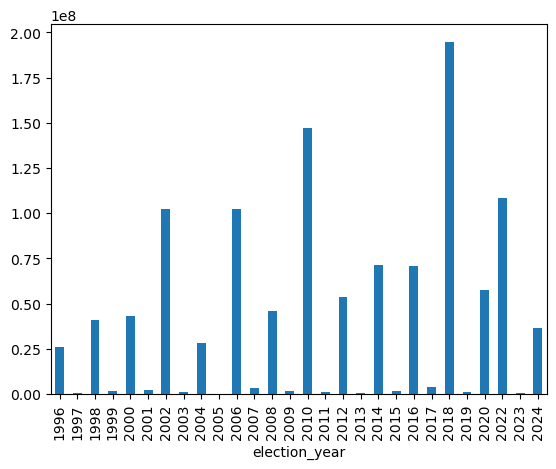

In [141]:
df_total3.groupby('election_year')['Candidate_expenditure'].sum().plot(kind = 'bar')

### finding ratio of expenditures between winners and losers by office

In [144]:
# Step 1: Count occurrences of Won_general within each Office group
won_counts = df_total.groupby(['Office', 'Won_general'])['Candidate_expenditure'].mean()

# Step 2: Unstack the Won_general level to separate counts for 0 and 1
won_counts_unstacked = won_counts.unstack(fill_value=0)

# Step 3: Calculate the ratio (1 to 0)
won_counts_unstacked['Ratio'] = won_counts_unstacked[1] / won_counts_unstacked[0]

# Display the result
won_counts_unstacked.sort_values(by = 'Ratio')

Won_general,0.0,1.0,Ratio
Office,,,
STA,1.404867e+05,2.482096e+05,1.766784
ATG,9.968733e+05,2.453562e+06,2.461257
STR,5.484104e+04,1.927813e+05,3.515274
CFO,8.093302e+05,2.959009e+06,3.656121
STS,1.054740e+05,4.233235e+05,4.013534
AGR,3.060730e+05,2.124472e+06,6.941063
GOV,2.474567e+06,2.118523e+07,8.561184


### finding ratio of expenditures between 1st and 2nd placers

In [147]:
# Step 1: Count occurrences of Won_general within each Office group
won_counts1 = df_total.groupby(['Office', 'Place_general'])['Candidate_expenditure'].mean()

# Step 2: Unstack the Won_general level to separate counts for 0 and 1
won_counts1_unstacked = won_counts1.unstack(fill_value=0)

# Step 3: Calculate the ratio (1 to 0)
won_counts1_unstacked['Ratio'] = won_counts1_unstacked[1] / won_counts1_unstacked[2]

#Display the result
won_counts1_unstacked.sort_values(by = 'Ratio')
won_counts1_unstacked[[1,2,'Ratio']].sort_values(by = 'Ratio')

Place_general,1.0,2.0,Ratio
Office,,,
STA,2.417455e+05,1.533974e+05,1.575943
ATG,2.453562e+06,1.415241e+06,1.733671
GOV,2.118523e+07,1.148326e+07,1.844880
CFO,2.959009e+06,1.289922e+06,2.293944
STR,1.882114e+05,6.233140e+04,3.019529
STS,4.106780e+05,1.202200e+05,3.416055
AGR,2.124472e+06,4.315754e+05,4.922598


### Expenditures and election participation by office and district

In [150]:
dist_exp = pd.DataFrame(df_total3.groupby(['Office','District'])[['Candidate_expenditure','RaceVoterPool_general','RaceVoterPool_primary']].mean())
dist_exp['Expenditure per voter'] = dist_exp['Candidate_expenditure']/dist_exp['RaceVoterPool_general']
dist_exp['General vs Primary participation'] = dist_exp['RaceVoterPool_general']/dist_exp['RaceVoterPool_primary']
dist_exp

Candidate_expenditure  RaceVoterPool_general  \
Office District                                                 
AGR    999                6.312534e+05           5.642062e+06   
ATG    999                1.120844e+06           5.879483e+06   
CFO    999                1.157488e+06           6.204058e+06   
GOV    999                3.001577e+06           6.185453e+06   
STA    1                  5.370867e+04                    NaN   
       2                  1.073536e+05           1.894470e+05   
       3                  3.874182e+04           7.534200e+04   
       4                  2.130581e+05           3.156590e+05   
       5                  3.701415e+04                    NaN   
       6                  1.024616e+05           6.361770e+05   
       7                  8.132646e+04           3.559556e+05   
       8                  8.079395e+04           1.340940e+05   
       9                  1.026109e+05           6.087290e+05   
       10                 1.241489e+05                    NaN   
       11                 3.511799e+05           6.695642e+05   
       12                 1.100541e+05           4.167485e+05   
       13                 2.106699e+05           4.736465e+05   
       14                 1.590995e+05           1.183390e+05   
       15                 1.938712e+05           5.013021e+05   
       16                 3.795033e+04           3.916418e+04   
       17                 1.183202e+05           8.132795e+05   
       18                 5.233832e+04           4.524500e+05   
       19                 2.875912e+04                    NaN   
       20                 1.139409e+05           4.047430e+05   
STR    1                  6.123595e+04           5.536530e+04   
       2                  6.788251e+04           5.742211e+04   
       3                  7.982185e+04           4.962970e+04   
       4                  8.280025e+04           5.774618e+04   
       5                  1.042877e+05           5.331065e+04   
       6                  1.071241e+05           5.137022e+04   
       7                  1.001485e+05           4.800723e+04   
       8                  5.115250e+04           4.550000e+04   
       9                  1.163322e+05           7.584950e+04   
       10                 5.502245e+04           5.553025e+04   
       11                 8.215469e+04           6.235286e+04   
       12                 6.766101e+04           5.638006e+04   
       13                 4.155836e+04           4.491667e+04   
       14                 6.243699e+04           5.649225e+04   
       15                 1.141663e+05           4.443454e+04   
       16                 1.026629e+05           5.272686e+04   
       17                 8.462841e+04           7.272265e+04   
       18                 1.121321e+05           6.847428e+04   
       19                 7.816291e+04           7.306400e+04   
       20                 7.069551e+04           6.927073e+04   
       21                 1.428975e+05           6.376363e+04   
       22                 8.824917e+04           6.501444e+04   
       23                 5.372073e+04           5.736933e+04   
       24                 7.620893e+04           6.009117e+04   
       25                 6.536263e+04           7.196745e+04   
       26                 8.505031e+04           5.979326e+04   
       27                 8.638269e+04           5.053267e+04   
       28                 9.002255e+04           6.487373e+04   
       29                 9.425578e+04           6.390925e+04   
       30                 9.556593e+04           6.279592e+04   
       31                 6.419575e+04           6.037142e+04   
       32                 6.463778e+04           6.305262e+04   
       33                 6.479768e+04           6.485252e+04   
       34                 7.090295e+04           5.392177e+04   
       35                 1.013984e+05           5.027512e+04   
       36                 7.420307e+04           4.3

In [152]:
correlation = df_total3['Race_expenditure'].corr(df_total3['RaceVoterPool_general'])
print(correlation)
correlation = df_total3['Race_expenditure'].corr(df_total3['RaceVoterPool_primary'])
print(correlation)

0.6541409422201534
0.7238394817936936


# Determining if total expenditure increases for close races

In [155]:
#creating a dataframe of only the top two candidates by race
top_two = df_total3[(df_total3['Place_general'] == 1) | (df_total3['Place_general'] == 2)].copy()
col_list = top_two.columns.to_list()
top_two = top_two[col_list[0:15]]
top_two

,election_year,election_type,Candidate Name,CanNameLast,CanNameFirst,Party,Office,District,Candidate_expenditure,Race_expenditure,Won_general,Place_general,VoteShare_general,TotalCanVotes_general,RaceVoterPool_general
416,2024,House_35,"Booth, Erika",Booth,Erika,REP,STR,35,322850.58,756242.46,0.0,2.0,0.486731,10803.0,22195.0
417,2024,House_35,"Keen, Tom",Keen,Tom,DEM,STR,35,143424.27,756242.46,1.0,1.0,0.513269,11392.0,22195.0
423,2023,House_118,"Redondo, Mike",Redondo,Mike,REP,STR,118,203829.69,291689.86,1.0,1.0,0.517910,4540.0,8766.0
424,2023,House_118,"Farias, Johnny Gonzalo",Farias,Johnny Gonzalo,DEM,STR,118,87860.17,291689.86,0.0,2.0,0.456308,4000.0,8766.0
430,2023,House_24,"Fox, Robert ""Foxy""",Fox,"Robert ""Foxy""",WRI,STR,24,10350.00,494481.92,0.0,2.0,0.116675,883.0,7568.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6389,1996,General,"Campbell, Walter ""Skip""",Campbell,"Walter ""Skip""",DEM,STS,33,356125.11,580162.32,1.0,1.0,0.676550,95679.0,141422.0
6484,1996,General,"Martin, Anthony R. ""Andy""",Martin,"Anthony R. ""Andy""",REP,STS,35,93265.07,529824.32,0.0,2.0,0.274239,31919.0,116391.0
6387,1996,General,"Rossin, Tom",Rossin,Tom,DEM,STS,35,427668.15,529824.32,1.0,1.0,0.725761,84472.0,116391.0
6729,1996,House_33,"Feeney, Tom",Feeney,Tom,REP,STR,33,149918.00,254742.45,1.0,1.0,0.547845,7105.0,12969.0


In [157]:
# vote differentials
top_two['VoteDiff_abs'] = top_two.groupby(['election_year','election_type','Office','District'])['TotalCanVotes_general'].diff().abs()
top_two['VoteDiff_%'] = top_two.groupby(['election_year','election_type','Office','District'])['VoteShare_general'].diff().abs()


# Binary variable indicating tight races (e.g., margin <= 5%)
top_two['tight_race'] = np.where(top_two['VoteDiff_%'] <= 0.05, 1, 0)

# finance differentials
top_two['ExpenditureDiff_%_top2'] = top_two.groupby(['election_year','election_type','Office'
                                                ,'District'])['Candidate_expenditure'].diff().abs()/(
                               top_two.groupby(['election_year','election_type','Office'
                                                ,'District'])['Candidate_expenditure'].transform('sum'))
top_two['ExpenditureDiff_%_racewide'] = top_two.groupby(['election_year','election_type','Office'
                                                ,'District'])['Candidate_expenditure'].diff().abs()/top_two['Race_expenditure']

top_two['ExpenditureDiff_abs'] = top_two.groupby(['election_year','election_type','Office'
                                                ,'District'])['Candidate_expenditure'].diff().abs()
    

top_two

,election_year,election_type,Candidate Name,CanNameLast,CanNameFirst,Party,Office,District,Candidate_expenditure,Race_expenditure,Won_general,Place_general,VoteShare_general,TotalCanVotes_general,RaceVoterPool_general,VoteDiff_abs,VoteDiff_%,tight_race,ExpenditureDiff_%_top2,ExpenditureDiff_%_racewide,ExpenditureDiff_abs
416,2024,House_35,"Booth, Erika",Booth,Erika,REP,STR,35,322850.58,756242.46,0.0,2.0,0.486731,10803.0,22195.0,NaN,NaN,0,NaN,NaN,NaN
417,2024,House_35,"Keen, Tom",Keen,Tom,DEM,STR,35,143424.27,756242.46,1.0,1.0,0.513269,11392.0,22195.0,589.0,0.026538,1,0.384808,0.237260,179426.31
423,2023,House_118,"Redondo, Mike",Redondo,Mike,REP,STR,118,203829.69,291689.86,1.0,1.0,0.517910,4540.0,8766.0,NaN,NaN,0,NaN,NaN,NaN
424,2023,House_118,"Farias, Johnny Gonzalo",Farias,Johnny Gonzalo,DEM,STR,118,87860.17,291689.86,0.0,2.0,0.456308,4000.0,8766.0,540.0,0.061602,0,0.397578,0.397578,115969.52
430,2023,House_24,"Fox, Robert ""Foxy""",Fox,"Robert ""Foxy""",WRI,STR,24,10350.00,494481.92,0.0,2.0,0.116675,883.0,7568.0,NaN,NaN,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6389,1996,General,"Campbell, Walter ""Skip""",Campbell,"Walter ""Skip""",DEM,STS,33,356125.11,580162.32,1.0,1.0,0.676550,95679.0,141422.0,49936.0,0.353099,0,0.909301,0.584678,339207.90
6484,1996,General,"Martin, Anthony R. ""Andy""",Martin,"Anthony R. ""Andy""",REP,STS,35,93265.07,529824.32,0.0,2.0,0.274239,31919.0,116391.0,NaN,NaN,0,NaN,NaN,NaN
6387,1996,General,"Rossin, Tom",Rossin,Tom,DEM,STS,35,427668.15,529824.32,1.0,1.0,0.725761,84472.0,116391.0,52553.0,0.451521,0,0.641931,0.631158,334403.08
6729,1996,House_33,"Feeney, Tom",Feeney,Tom,REP,STR,33,149918.00,254742.45,1.0,1.0,0.547845,7105.0,12969.0,NaN,NaN,0,NaN,NaN,NaN


Text(0.5, 1.0, 'Expenditures vs. Absolute Vote Margin')

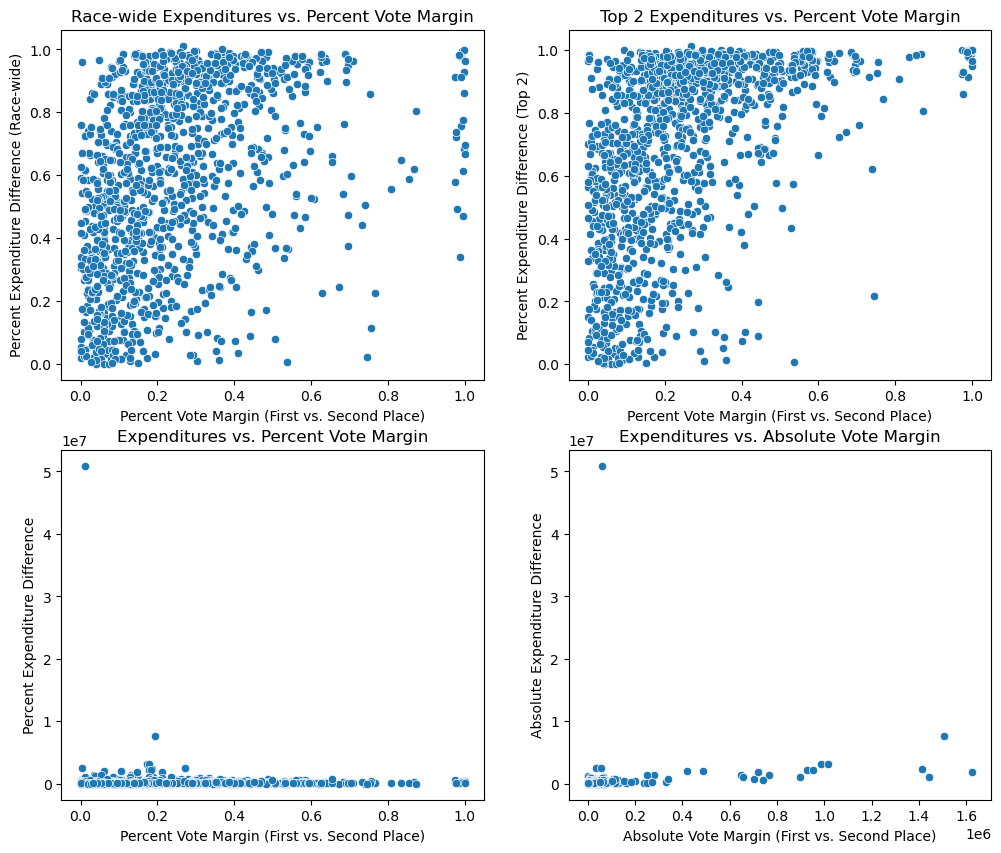

In [159]:
fig, axes = plt.subplots(2, 2, figsize = (12,10))

# Plot 1: Percent Vote Margin vs Percent Expenditure Difference (Race-wide)
sns.scatterplot(data=top_two, x='VoteDiff_%', y='ExpenditureDiff_%_racewide', ax=axes[0, 0])
axes[0, 0].set_xlabel('Percent Vote Margin (First vs. Second Place)')
axes[0, 0].set_ylabel('Percent Expenditure Difference (Race-wide)')
axes[0, 0].set_title('Race-wide Expenditures vs. Percent Vote Margin')

# Plot 2: Percent Vote Margin vs Percent Expenditure Difference (Top 2)
sns.scatterplot(data=top_two, x='VoteDiff_%', y='ExpenditureDiff_%_top2', ax=axes[0, 1])
axes[0, 1].set_xlabel('Percent Vote Margin (First vs. Second Place)')
axes[0, 1].set_ylabel('Percent Expenditure Difference (Top 2)')
axes[0, 1].set_title('Top 2 Expenditures vs. Percent Vote Margin')

# Plot 3: percent vote margin vs absolute expenditure margin
sns.scatterplot(data=top_two, x='VoteDiff_%', y='ExpenditureDiff_abs', ax=axes[1, 0])
axes[1, 0].set_xlabel('Percent Vote Margin (First vs. Second Place)')
axes[1, 0].set_ylabel('Percent Expenditure Difference')
axes[1, 0].set_title('Expenditures vs. Percent Vote Margin')

# Plot 4: Absolute Vote Margin vs Absolute Expenditure Difference
sns.scatterplot(data=top_two, x='VoteDiff_abs', y='ExpenditureDiff_abs', ax=axes[1, 1])
axes[1, 1].set_xlabel('Absolute Vote Margin (First vs. Second Place)')
axes[1, 1].set_ylabel('Absolute Expenditure Difference')
axes[1, 1].set_title('Expenditures vs. Absolute Vote Margin')


In [161]:
top_2 = top_two.dropna(subset = 'VoteDiff_abs')
top_2

,election_year,election_type,Candidate Name,CanNameLast,CanNameFirst,Party,Office,District,Candidate_expenditure,Race_expenditure,Won_general,Place_general,VoteShare_general,TotalCanVotes_general,RaceVoterPool_general,VoteDiff_abs,VoteDiff_%,tight_race,ExpenditureDiff_%_top2,ExpenditureDiff_%_racewide,ExpenditureDiff_abs
417,2024,House_35,"Keen, Tom",Keen,Tom,DEM,STR,35,143424.27,7.562425e+05,1.0,1.0,0.513269,11392.0,22195.0,589.0,0.026538,1,0.384808,0.237260,179426.31
424,2023,House_118,"Farias, Johnny Gonzalo",Farias,Johnny Gonzalo,DEM,STR,118,87860.17,2.916899e+05,0.0,2.0,0.456308,4000.0,8766.0,540.0,0.061602,0,0.397578,0.397578,115969.52
426,2023,House_24,"Chamberlin, Ryan",Chamberlin,Ryan,REP,STR,24,122180.00,4.944819e+05,1.0,1.0,0.883325,6685.0,7568.0,5802.0,0.766649,0,0.843809,0.226156,111830.00
610,2022,General,"Blemur, Naomi Esther",Blemur,Naomi Esther,DEM,AGR,999,118961.21,2.823496e+06,0.0,2.0,0.406996,3095786.0,7606430.0,1414858.0,0.186008,0,0.910134,0.853409,2409597.39
525,2022,General,"Ayala, Aramis",Ayala,Aramis,DEM,ATG,999,217729.90,2.724168e+06,0.0,2.0,0.394146,3025943.0,7677222.0,1625336.0,0.211709,0,0.811972,0.690292,1880471.10
455,2022,General,"Hattersley, Adam",Hattersley,Adam,DEM,CFO,999,388931.34,1.801412e+06,0.0,2.0,0.405239,3085697.0,7614508.0,1443114.0,0.189522,0,0.567519,0.566635,1020742.32
432,2022,General,"Crist, Charlie",Crist,Charlie,DEM,GOV,999,18093666.22,4.814077e+07,0.0,2.0,0.399711,3106313.0,7771399.0,1507897.0,0.194032,0,0.174747,0.159171,7662627.98
503,2022,General,"Miller, Allison",Miller,Allison,DEM,STA,6,267535.30,6.837864e+05,0.0,2.0,0.411670,261895.0,636177.0,112387.0,0.176660,0,0.217489,0.217489,148715.79
870,2022,General,"Mathis, Franscine C.",Mathis,Franscine C.,DEM,STR,1,3295.98,4.001413e+05,0.0,2.0,0.307295,19087.0,62113.0,23939.0,0.385410,0,0.981361,0.867354,347063.94
798,2022,General,"Taylor, Carollyn Rabeca",Taylor,Carollyn Rabeca,DEM,STR,2,13172.89,2.607637e+05,0.0,2.0,0.363954,25440.0,69899.0,19019.0,0.272093,0,0.890845,0.824558,215014.72


In [163]:
import statsmodels.api as sm
import numpy as np



# Aggregate data by race-level identifiers
race_data = top_2.groupby(['election_year', 'election_type', 'Office', 'District']).agg(
    tight_race = ('tight_race','max'),
    total_expenditure=('Candidate_expenditure', 'sum'),
    total_votes=('TotalCanVotes_general', 'sum'),
    vote_margin=('VoteDiff_%', 'mean')  # Average vote margin in each race
).reset_index()


In [165]:
# Define the independent variable (vote_margin) and dependent variable (total_expenditure)
X = race_data['vote_margin']
X = sm.add_constant(X)  # Adds a constant term to the model
y = race_data['total_expenditure']

# Fit the model
model = sm.OLS(y, X).fit()

# Print the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      total_expenditure   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     8.452
Date:                Thu, 05 Dec 2024   Prob (F-statistic):            0.00371
Time:                        12:21:31   Log-Likelihood:                -18174.
No. Observations:                1202   AIC:                         3.635e+04
Df Residuals:                    1200   BIC:                         3.636e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        2.694e+05   4.11e+04      6.551      

In [167]:
# Logistic regression for tight race prediction
X = race_data[['total_expenditure']] 
X = sm.add_constant(X)
y = race_data['tight_race']  # Binary variable for close races (0 or 1)

# Fit logistic regression model
model = sm.Logit(y, X).fit()

# Print the summary
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.364699
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:             tight_race   No. Observations:                 1202
Model:                          Logit   Df Residuals:                     1200
Method:                           MLE   Df Model:                            1
Date:                Thu, 05 Dec 2024   Pseudo R-squ.:                0.009463
Time:                        12:21:32   Log-Likelihood:                -438.37
converged:                       True   LL-Null:                       -442.56
Covariance Type:            nonrobust   LLR p-value:                  0.003802
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -2.0332      0.091    -22.383      0.000      -2.211      -1.855
total_ex

In [169]:
df = pd.DataFrame(df_total3.groupby('election_type').count())
df

,election_year,Candidate Name,CanNameLast,CanNameFirst,Party,Office,District,Candidate_expenditure,Race_expenditure,Won_general,Place_general,VoteShare_general,TotalCanVotes_general,RaceVoterPool_general,Won_primary,Place_primary,VoteShare_primary,TotalCanVotes_primary,RaceVoterPool_primary,Won_runoff,Place_runoff,VoteShare_runoff,TotalCanVotes_runoff,RaceVoterPool_runoff
election_type,,,,,,,,,,,,,,,,,,,,,,,,
Congr_1_and_House_1,8,8,8,8,8,8,8,8,8,2,2,2,2,2,8,8,8,8,8,2,2,2,2,2
General,6395,6395,6395,6395,6395,6395,6395,6395,6395,2718,2716,2716,2716,2718,2538,2538,2538,2538,2538,80,80,80,80,80
House_101,6,6,6,6,6,6,6,6,6,2,2,2,2,2,4,4,4,4,4,0,0,0,0,0
House_103,2,2,2,2,2,2,2,2,2,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0
House_110,4,4,4,4,4,4,4,4,4,2,2,2,2,2,3,3,3,3,3,0,0,0,0,0
House_114,5,5,5,5,5,5,5,5,5,3,3,3,3,3,2,2,2,2,2,0,0,0,0,0
House_118,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,0,0,0,0,0,0,0,0,0
House_13,6,6,6,6,6,6,6,6,6,2,2,2,2,2,4,4,4,4,4,0,0,0,0,0
House_15,5,5,5,5,5,5,5,5,5,2,2,2,2,2,4,4,4,4,4,0,0,0,0,0


In [179]:
df_total3[(df_total3['election_year'] == 2002) & (df_total3['Office'] == 'GOV')]

,election_year,election_type,Candidate Name,CanNameLast,CanNameFirst,Party,Office,District,Candidate_expenditure,Race_expenditure,Won_general,Place_general,VoteShare_general,TotalCanVotes_general,RaceVoterPool_general,Won_primary,Place_primary,VoteShare_primary,TotalCanVotes_primary,RaceVoterPool_primary,Won_runoff,Place_runoff,VoteShare_runoff,TotalCanVotes_runoff,RaceVoterPool_runoff
5431,2002,General,"Adkins, Bob",Adkins,Bob,WRI,GOV,999,1130.29,57199175.58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5432,2002,General,"Grant, Nancy",Grant,Nancy,WRI,GOV,999,1129.90,57199175.58,0.0,4.0,0.000009,44.0,5100581.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5444,2002,General,"Fruit, Rachele",Fruit,Rachele,WRI,GOV,999,622.69,57199175.58,0.0,5.0,0.000005,24.0,5100581.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5456,2002,General,"Reed, C.C.",Reed,C.C.,WRI,GOV,999,164.10,57199175.58,0.0,6.0,0.000001,7.0,5100581.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5044,2002,General,"Bush, Jeb",Bush,Jeb,REP,GOV,999,7618587.80,57199175.58,1.0,1.0,0.560102,2856845.0,5100581.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5455,2002,General,"Ivers, Nancy",Ivers,Nancy,REP,GOV,999,180.06,57199175.58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5043,2002,General,"Lipner, Ryan Adam",Lipner,Ryan Adam,NPA,GOV,999,40000200.00,57199175.58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5339,2002,General,"Kunst, Robert (Bob)",Kunst,Robert (Bob),NPA,GOV,999,17784.33,57199175.58,0.0,3.0,0.008242,42039.0,5100581.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5427,2002,General,"Calhoun, Mike",Calhoun,Mike,NPA,GOV,999,1300.00,57199175.58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5045,2002,General,"McBride, Bill",McBride,Bill,DEM,GOV,999,6504241.22,57199175.58,0.0,2.0,0.431603,2201427.0,5100581.0,1.0,1.0,0.443879,602352.0,1357017.0,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_total3[df_total3['election_year'] == 2002].groupby('Party').sum('Candidate_expenditure')

# Data play space

In [ ]:
df